In [64]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [65]:
from tensorflow.keras.applications import VGG16
with tf.device('/device:GPU:0'):
# VGG16은 Convolution Layer 16개, Fc Layer는 3개로 구성된 Network
    base_model = VGG16(weights= 'imagenet',
                      include_top=False,
                      input_shape=(64,256,3))

    base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 256, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 256, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 256, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 64, 128)       0     

In [66]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './image_data'

with tf.device('/device:GPU:0'):

    imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    trainGen = imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        subset='training',
        class_mode="sparse"
    )

    validationGen = imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        subset='validation',
        class_mode="sparse"
    )

Found 1114 images belonging to 2 classes.
Found 277 images belonging to 2 classes.


In [76]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):

    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(64,256,3))

    model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(2*8*512,)))

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dense(2,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 100
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=1114//32, 
        validation_data=validationGen,
        validation_steps=277//32,
        verbose=1
    )



Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 8, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 514       
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 0.5982 - sparse_categorical_accuracy: 0.6914
Epoch 00001: val_loss improved from inf to 0.62102, saving model to ./model/recycle.h5
34/34 [=======================

33/34 [============================>.] - ETA: 0s - loss: 0.1317 - sparse_categorical_accuracy: 0.9552
Epoch 00022: val_loss improved from 0.54447 to 0.54191, saving model to ./model/recycle.h5
34/34 [==============================] - 2s 67ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.5419 - val_sparse_categorical_accuracy: 0.7539
Epoch 23/100
33/34 [============================>.] - ETA: 0s - loss: 0.1292 - sparse_categorical_accuracy: 0.9610
Epoch 00023: val_loss did not improve from 0.54191
34/34 [==============================] - 2s 48ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.7344
Epoch 24/100
33/34 [============================>.] - ETA: 0s - loss: 0.1221 - sparse_categorical_accuracy: 0.9581
Epoch 00024: val_loss did not improve from 0.54191
34/34 [==============================] - 2s 48ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.5722 - val_sparse_

33/34 [============================>.] - ETA: 0s - loss: 0.0643 - sparse_categorical_accuracy: 0.9848
Epoch 00046: val_loss did not improve from 0.49818
34/34 [==============================] - 2s 48ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.5153 - val_sparse_categorical_accuracy: 0.8008
Epoch 47/100
33/34 [============================>.] - ETA: 0s - loss: 0.0623 - sparse_categorical_accuracy: 0.9867
Epoch 00047: val_loss did not improve from 0.49818
34/34 [==============================] - 2s 48ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.5560 - val_sparse_categorical_accuracy: 0.8008
Epoch 48/100
33/34 [============================>.] - ETA: 0s - loss: 0.0611 - sparse_categorical_accuracy: 0.9895
Epoch 00048: val_loss did not improve from 0.49818
34/34 [==============================] - 2s 48ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.5663 - val_sparse_categorical_accuracy: 0.7930
Epoch 49/10

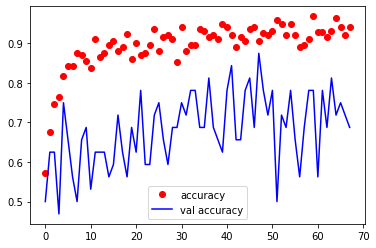

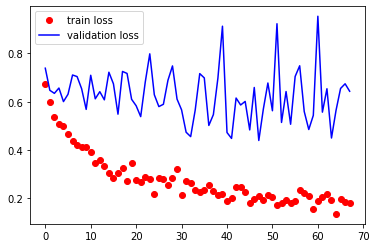

In [70]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

## CNN

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator



with tf.device('/device:GPU:0'):
    
    def get_lr_callback():
        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 12 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback
    
    
    
    
    model = Sequential()
    
    model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(64,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128,
                     kernel_size=(3,3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
#     model.add(Conv2D(filters=128,
#                      kernel_size=(3,3),
#                      activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(filters=256,
                     kernel_size=(3,3),
                     activation='relu'))
    
    model.add(GlobalAveragePooling2D())

    
    model.add(Dense(units=2,
                    activation='softmax'))
    
    model.summary()

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_cnn.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

    epochs = 100
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=1114//32, 
        validation_data=validationGen,
        validation_steps=277//32,
        verbose=1
    )

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 62, 254, 32)       896       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 29, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 14, 62, 64)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 12, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 6, 30, 128)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 4, 28, 256)      

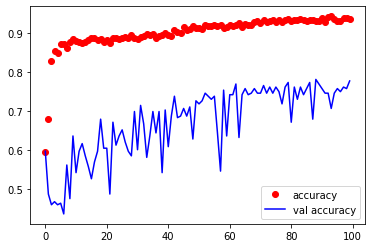

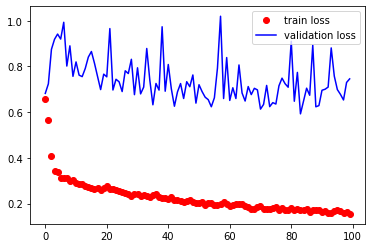

In [79]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

In [78]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator



with tf.device('/device:GPU:0'):
    
    def get_lr_callback():
        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 12 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback
    
    
    
    
    model = Sequential()
    
    model.add(Conv2D(filters=16,
                     kernel_size=(2,2),
                     activation='relu',
                     input_shape=(64,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,
                     kernel_size=(2,2),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64,
                     kernel_size=(2,2),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    model.add(Conv2D(filters=128,
                     kernel_size=(2,2),
                     activation='relu'))
    
    model.add(Conv2D(filters=256,
                     kernel_size=(2,2),
                     activation='relu'))

    model.add(GlobalAveragePooling2D())

    
    model.add(Dense(units=2,
                    activation='softmax'))
    
    model.summary()

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_cnn.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=100)

    epochs = 100
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=1117//32, 
        validation_data=validationGen,
        validation_steps=277//32,
        verbose=1
    )
 

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 63, 255, 16)       208       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 31, 127, 16)       0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 30, 126, 32)       2080      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 15, 63, 32)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 14, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 7, 31, 64)         0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 6, 30, 128)      

Epoch 21/100
34/34 [==============================] - ETA: 0s - loss: 0.2751 - sparse_categorical_accuracy: 0.8817
Epoch 00021: val_loss did not improve from 0.68206
34/34 [==============================] - 1s 34ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.7545 - val_sparse_categorical_accuracy: 0.6055
Epoch 22/100
34/34 [==============================] - ETA: 0s - loss: 0.2622 - sparse_categorical_accuracy: 0.8752
Epoch 00022: val_loss did not improve from 0.68206
34/34 [==============================] - 1s 36ms/step - loss: 0.2622 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.4883
Epoch 23/100
33/34 [============================>.] - ETA: 0s - loss: 0.2675 - sparse_categorical_accuracy: 0.8838
Epoch 00023: val_loss did not improve from 0.68206
34/34 [==============================] - 1s 37ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.6969 - val_sparse_categorical_accuracy: 0.671

33/34 [============================>.] - ETA: 0s - loss: 0.2139 - sparse_categorical_accuracy: 0.8990
Epoch 00045: val_loss did not improve from 0.62589
34/34 [==============================] - 1s 36ms/step - loss: 0.2135 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.7251 - val_sparse_categorical_accuracy: 0.6875
Epoch 46/100
34/34 [==============================] - ETA: 0s - loss: 0.2079 - sparse_categorical_accuracy: 0.9150
Epoch 00046: val_loss did not improve from 0.62589
34/34 [==============================] - 1s 36ms/step - loss: 0.2079 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.7070
Epoch 47/100
33/34 [============================>.] - ETA: 0s - loss: 0.2114 - sparse_categorical_accuracy: 0.9057
Epoch 00047: val_loss did not improve from 0.62589
34/34 [==============================] - 1s 37ms/step - loss: 0.2095 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.7332 - val_sparse_categorical_accuracy: 0.6875
Epoch 48/10

Epoch 70/100
33/34 [============================>.] - ETA: 0s - loss: 0.1853 - sparse_categorical_accuracy: 0.9286
Epoch 00070: val_loss did not improve from 0.62362
34/34 [==============================] - 1s 36ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.7461
Epoch 71/100
33/34 [============================>.] - ETA: 0s - loss: 0.1844 - sparse_categorical_accuracy: 0.9267
Epoch 00071: val_loss improved from 0.62362 to 0.61331, saving model to ./model/recycle_cnn.h5
34/34 [==============================] - 1s 37ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9242 - val_loss: 0.6133 - val_sparse_categorical_accuracy: 0.7461
Epoch 72/100
33/34 [============================>.] - ETA: 0s - loss: 0.1721 - sparse_categorical_accuracy: 0.9343
Epoch 00072: val_loss did not improve from 0.61331
34/34 [==============================] - 1s 37ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.9325 - val_loss: 0.6

33/34 [============================>.] - ETA: 0s - loss: 0.1593 - sparse_categorical_accuracy: 0.9419
Epoch 00094: val_loss did not improve from 0.59257
34/34 [==============================] - 1s 36ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.7070
Epoch 95/100
33/34 [============================>.] - ETA: 0s - loss: 0.1723 - sparse_categorical_accuracy: 0.9333
Epoch 00095: val_loss did not improve from 0.59257
34/34 [==============================] - 1s 37ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9344 - val_loss: 0.7576 - val_sparse_categorical_accuracy: 0.7461
Epoch 96/100
34/34 [==============================] - ETA: 0s - loss: 0.1703 - sparse_categorical_accuracy: 0.9307
Epoch 00096: val_loss did not improve from 0.59257
34/34 [==============================] - 1s 37ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.7578
Epoch 97/10

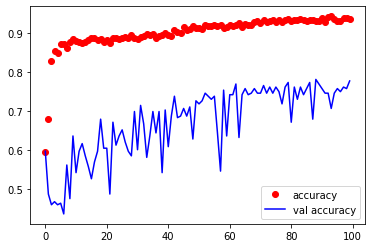

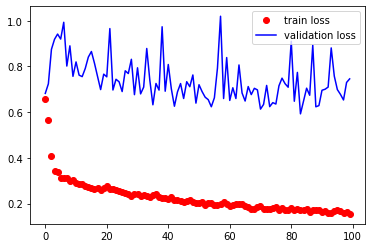

In [80]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()